In [12]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib
import csv

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [13]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


In [59]:
task = 'localizer'
n_trunc_beginning=14 #Number of volumes to trim from beginning of run
n_trunc_end=10 #Number of volumes to trim from end of run
ROIs=['bilateral_hippo','bilateral_oc-temp']

subList = ['005','006']


# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/mainanalysis')
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer,load_adderzip_epi_data, shift_timing, label2TR, mask_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_label_dict, n_runs, run_names, adderzip_TR, adderzip_hrf_lag, TRs_run

print('TASKS:', task)
print('LIST OF ALL TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_localizer = n_runs[task_index]

TRs_run_localizer=TRs_run[task_index]-n_trunc_beginning-n_trunc_end

trials_run_localizer = 90

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/'
fmriprep_dir=adderzip_bids_dir + 'derivatives/fmriprep/'
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

print('ROIs = %s' % (ROIs))
print('Labels = %s' % (adderzip_label_dict))
print('number of runs = %d' % (n_runs_localizer))
print('TR = %s seconds' % (adderzip_TR))
print('TRs per run before trimming = %s' % (TRs_run[task_index]))
print('%d volumes trimmed from beginning of each run' % (n_trunc_beginning))
print('%d volumes trimmed from end of each run' % (n_trunc_end))
print('TRs per run after trimming = %s' % (TRs_run_localizer))

TASKS: localizer
LIST OF ALL TASKS: ['localizer']
task index: 0

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
number of runs = 3
TR = 1.5 seconds
TRs per run before trimming = 194
14 volumes trimmed from beginning of each run
10 volumes trimmed from end of each run
TRs per run after trimming = 170


In [60]:
#load file for each subject and concatenate
for eachParti in range (len(subList)):
    sub = subList[eachParti]
    
    file_dir = data_dir + '/classifier_localizer_oc-temp/classifier_results_%s.csv' % sub
    
    partiFile = open(file_dir)
    partiFile = csv.reader(partiFile)
    partiFile = list(partiFile)
    partiFile = partiFile[1::]
    partiFile = np.array(partiFile)
    partiFile = np.float64(partiFile)
    
    if eachParti == 0:
        classifier_allSubj = partiFile
    else:
        classifier_allSubj = np.vstack((classifier_allSubj,partiFile))
    
print('classifier results for all subjects concatenated')
print('shape=',classifier_allSubj.shape)
print('# subject', 'classifier', 'run', 'TR', 'trial_type', 'prob')
print(classifier_allSubj)

#print(classifier_allSubj[0,0].dtype)
    
#sort by classifier type instead of subject
classifier_allSubj = classifier_allSubj[np.argsort(classifier_allSubj[:,1])]
    
print('# subject', 'classifier', 'run', 'TR', 'trial_type', 'prob')
print(classifier_allSubj)

classifier results for all subjects concatenated
shape= (1620, 6)
# subject classifier run TR trial_type prob
[[ 5.    1.    1.    1.    0.    0.05]
 [ 5.    1.    1.    2.    0.    0.19]
 [ 5.    1.    1.    3.    0.    0.05]
 ...
 [ 6.    3.    3.   88.    0.    0.05]
 [ 6.    3.    3.   89.    0.    0.05]
 [ 6.    3.    3.   90.    0.    0.05]]
# subject classifier run TR trial_type prob
[[ 5.    1.    1.    1.    0.    0.05]
 [ 6.    1.    2.    9.    0.    0.81]
 [ 6.    1.    2.    8.    0.    0.06]
 ...
 [ 5.    3.    2.   81.    1.    0.  ]
 [ 5.    3.    3.    5.    1.    1.  ]
 [ 6.    3.    3.   90.    0.    0.05]]


(540,)
(540,)


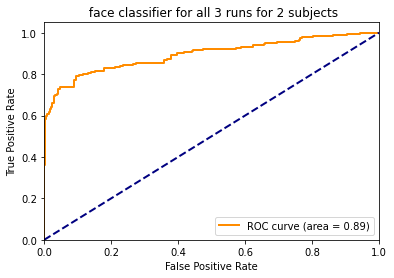

(540,)
(540,)


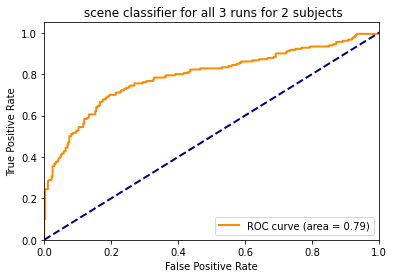

(540,)
(540,)


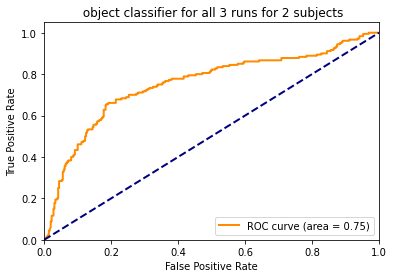

In [61]:
n_classifierTypes = 3
partiNum = len(subList)

for eachClassi in range(n_classifierTypes):
    
    if eachClassi == 0:
        classiType = 'face'
    elif eachClassi == 1:
        classiType = 'scene'
    elif eachClassi == 2:
        classiType = 'object'
    
    n_classifier_rows = trials_run_localizer * n_runs_localizer * partiNum #270*partiNum
    start = eachClassi * n_classifier_rows
    end = start + n_classifier_rows
    
    y_true = classifier_allSubj[start:end,4]
    print(y_true.shape)
    y_scores = classifier_allSubj[start:end,5]
    print(y_scores.shape)
    fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

    roc_auc = auc(fpr,tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title=' %s classifier for all 3 runs for %s subjects' % (classiType,partiNum)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()